In [42]:
# transformer plus a simple equations: learning some wave rules
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F
from wavefn import WaveFunction

batch_size = 8
block_size = 32
max_iter = 10000
epochs = 10
eval_interval = 500
learning_rate = 5e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embed = 64
n_head = 16
n_layer = 16
dropout = 0
text = []

# tokens set as integers
tokens = ['0','1','2','3','4','5','6','7','8','9'] #,'s','e']

# Example usage
wave_length = 32

# Let's make some waves! Not strictly needed, but repurposing the wave fn so keeping it for now
c = 1.0  # Wave speed
dx = 0.1  # Spatial step size
dt = 0.1  # Time step size
wave_fn = WaveFunction(c, dx, dt)

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[str(c)] for c in s]
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])  # Skipping the first and last items ('s' and 'e')
# Define an appropriate size for your validation batch
val_batch_size = batch_size  

# Function to generate a random initial wave profile
def generate_random_wave_profile(size):
    return (np.random.rand(size)*10).astype(int)

# Function to simulate wave sequence
def simulate_wave_sequence(batch_size, size):
    initial_profiles = [generate_random_wave_profile(size) for _ in range(batch_size)]
    final_profiles = []
    for profile in initial_profiles:
        # Adjusted to capture the transformed profile correctly
        _, transformed_profile = wave_fn.simulate_wave_equation(profile)
        transformed_profile_clipped = np.clip(transformed_profile, 0, 9).astype(int)
        # Convert numpy array to list of strings
        transformed_profile_as_str_list = [str(num) for num in transformed_profile_clipped.tolist()]
        final_profiles.append(transformed_profile_as_str_list)
    return initial_profiles, final_profiles
# load data
def get_batch(batch_size, size, block_size):
    initial_profiles, final_profiles = simulate_wave_sequence(batch_size, size)
    X = torch.tensor([enc(profile)[:block_size] for profile in initial_profiles], dtype=torch.long)
    Y = torch.tensor([enc(profile)[:block_size] for profile in final_profiles], dtype=torch.long)
    return X.to(device), Y.to(device)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        # wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class SinusoidalActivation(nn.Module):
    def forward(self, x):
        # return torch.sin(x)
        return x + torch.sin(x) ** 2

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.GELU(),
            # SinusoidalActivation(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        attn_output = self.sa(self.ln1(x))
        x = x + attn_output  # add & norm for attention
        ffwd_output = self.ffwd(self.ln2(x))
        x = x + ffwd_output  # add & norm for feedforward
        return x

# bigram language model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1)  # Flatten targets to [batch_size * block_size]
            # targets = targets.view(-1, vocab_size)  # For MSE might need this encording.
            loss = F.cross_entropy(logits, targets) 
            # loss = F.mse_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # loss = F.l1_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx, idx_next), dim = 1)
        return idx
    
model = LanguageModel()
m = model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.5, centered=False)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
loss = None  # Initialize loss variable outside the loop

for epoch in range(epochs):
    for iter in range(max_iter // epochs):  # Distribute iterations across epochs
        model.train()
        xb, yb = get_batch(batch_size, wave_length, block_size)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        max_norm = 1
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        if iter % eval_interval == 0 and loss is not None:  # Validation logic
            model.eval()
            with torch.no_grad():
                xv, yv = get_batch(val_batch_size, wave_length, block_size)
                val_logits, val_loss = model(xv, yv)
                print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
            model.train()

    scheduler.step(val_loss)  # Update the learning rate at the end of each epoch

torch.save(model, 'models/cat_wave_model.pth')

Epoch 0, Iteration 0: Training Loss = 2.357375383377075, Validation Loss = 2.1293604373931885
Epoch 0, Iteration 500: Training Loss = 0.9316272139549255, Validation Loss = 0.9238788485527039
Epoch 1, Iteration 0: Training Loss = 0.21372535824775696, Validation Loss = 0.27869465947151184
Epoch 1, Iteration 500: Training Loss = 0.2060176134109497, Validation Loss = 0.1875283271074295
Epoch 2, Iteration 0: Training Loss = 0.10055897384881973, Validation Loss = 0.12121957540512085
Epoch 2, Iteration 500: Training Loss = 0.13142411410808563, Validation Loss = 0.09878724068403244
Epoch 3, Iteration 0: Training Loss = 0.08744771778583527, Validation Loss = 0.10202860087156296
Epoch 3, Iteration 500: Training Loss = 0.1094212457537651, Validation Loss = 0.10737394541501999
Epoch 4, Iteration 0: Training Loss = 0.044947512447834015, Validation Loss = 0.13242240250110626
Epoch 4, Iteration 500: Training Loss = 0.09322463721036911, Validation Loss = 0.12826918065547943
Epoch 5, Iteration 0: Train

Input is: [3 9 7 5 1 1 0 8 6 7 0 9 8 2 1 1 3 5 4 2 6 1 2 3 4 7 1 5 5 0 6 1]
Decoded Output: 97511086709821135426123471550612202000000000000000000000000000
Generated Output: 202000000000000000000000000000
Wavefn Output: [2 0 2 9 9 9 5 0 0 2 5 9 5 9 9 9 2 0 0 2 5 2 5 2 2 0 2 5 5 5 2 2]
Decoded values:  [2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


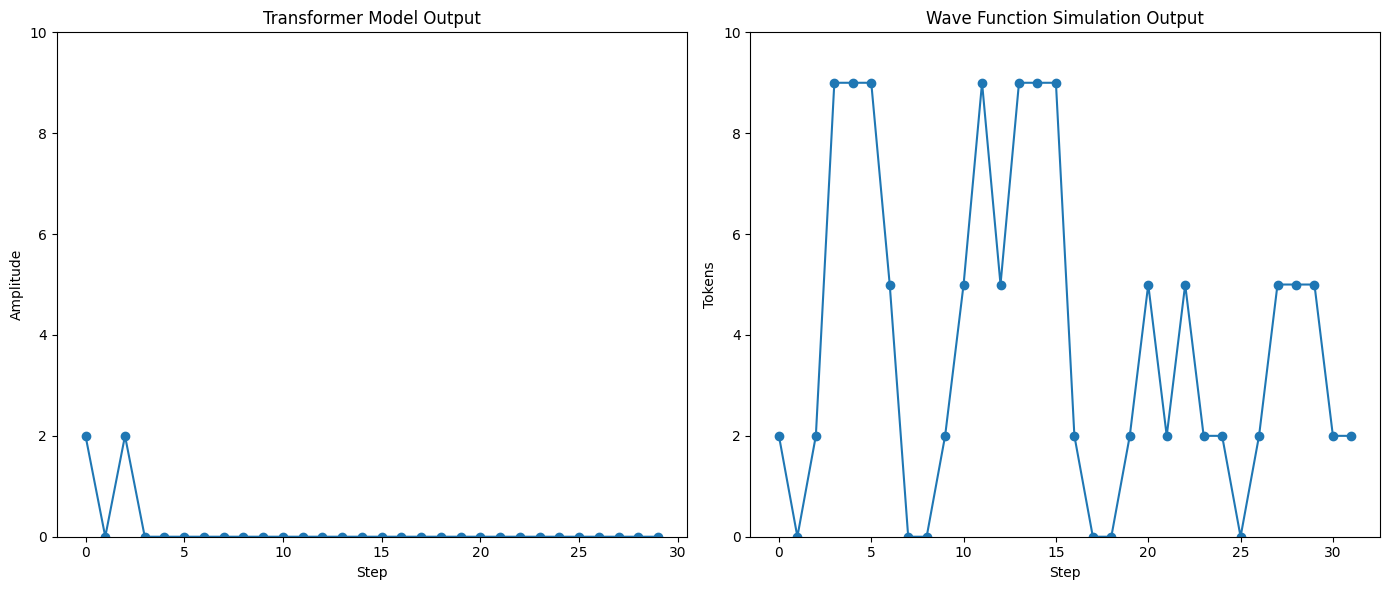

In [46]:
import matplotlib.pyplot as plt
import torch
# Load the model
model = torch.load('models/cat_wave_model.pth')
model.eval()
np.random.seed(42)  # Seed for reproducibility
input_length = 32
input = (np.random.rand(input_length)*10).astype(int)
print(f"Input is: {input}")
encoded_input = enc(input)

# Convert to a tensor and add a batch dimension (assuming your model expects a batch)
input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)
max_new_tokens = input_length  # Define how many new tokens you want to generate
output_tensor = model.generate(input_tensor, max_new_tokens=max_new_tokens)
decoded_output = dec(output_tensor[0].tolist())  # Assuming you're interested in the first item in the batch
generated_output = decoded_output[input_length:]# .split('e')[1]
_, sim_wave_output = wave_fn.simulate_wave_equation(input)
print("Decoded Output:", decoded_output)
print("Generated Output:", generated_output)
print("Wavefn Output:", sim_wave_output)

# # Plot!
decoded_values = [int(char) for char in generated_output]

print("Decoded values: ", decoded_values)
global_min = 0
global_max = 9

plt.figure(figsize=(14, 6))

# Plot for the Transformer Model Output
plt.subplot(1, 2, 1)
plt.plot(decoded_values, marker='o', linestyle='-')
plt.title('Transformer Model Output')
plt.xlabel('Step')
plt.ylabel('Amplitude')
plt.ylim(global_min, global_max+1)  # Set Y-axis limits to be the same for both plots

# Plot for the Wave Function Simulation Output
plt.subplot(1, 2, 2)
plt.plot(sim_wave_output, marker='o', linestyle='-')
plt.title('Wave Function Simulation Output')
plt.xlabel('Step')
plt.ylabel('Tokens')
plt.ylim(global_min, global_max+1)  # Set Y-axis limits to be the same for both plots

plt.tight_layout()
plt.show()
